In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.utils import simple_preprocess
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import models

In [3]:
data = pd.read_csv('../raw_data/emotion_data.csv')
data.head()

,Emotion,Text
0,sad,Layin n bed with a headache ughhhh...waitin o...
1,sad,Funeral ceremony...gloomy friday...
2,joy,wants to hang out with friends SOON!
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sad,"I should be sleep, but im not! thinking about ..."


### Clean data

In [5]:
def clean_data(dataframe):
    """
    clean and preprocess data
    """
    
    data = dataframe.copy()

    # Lowercase text
    data['clean_text'] = data['Text'].apply(
        lambda x: x.lower()
        )

    # Strip whitespace
    data['clean_text'] = data['clean_text'].apply(
        lambda x: x.strip()
        )

    # Remove numbers
    data['clean_text'] = data['clean_text'].apply(
        lambda x: ''.join(let for let in x if not let.isdigit())
        )

    # Remove punctuation
    data['clean_text'] = data['clean_text'].apply(
        lambda x: ''.join(let for let in x if not let in string.punctuation)
        )

    # Tokenization with nltk
    data['clean_text'] = data['clean_text'].apply(
        lambda x: word_tokenize(x)
    )
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     data['clean_text'] = data['clean_text'].apply(
#         lambda x: [word for word in x if word not in stop_words]
#         )

    # Lemmatizing with nltk
    lemmatizer = WordNetLemmatizer()
    data['clean_text'] = data['clean_text'].apply(
        lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x)
        )
    
    # Tokenizing text
    data['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data['clean_text']] 

    # Return data
    return data

In [6]:
emotions_df = clean_data(data)

### Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(emotions_df[['tokenized_text']], 
                                                        emotions_df[['Emotion']], 
                                                        test_size=0.3, 
                                                        random_state=15)

In [12]:
all_training_words = [word for tokens in X_train["tokenized_text"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in X_train["tokenized_text"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

531063 words total, with a vocabulary size of 39182
Max sentence length is 201


In [13]:
all_test_words = [word for tokens in X_test["tokenized_text"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in X_test["tokenized_text"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

226316 words total, with a vocabulary size of 22205
Max sentence length is 152


### Load pre-trained word2vec

In [16]:
word2vec_path = '../raw_data/google-vectors.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [17]:
MAX_SEQUENCE_LENGTH = 201
EMBEDDING_DIM = 300

In [18]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(X_train["tokenized_text"].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train["tokenized_text"].tolist())
train_word_index = tokenizer.word_index
print("Found %s unique tokens." % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)

Found 39182 unique tokens.


In [19]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
test_sequences = tokenizer.texts_to_sequences(X_test["tokenized_text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(train_embedding_weights.shape)

(39183, 300)


### Define Model

In [34]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [35]:
label_names = ['anger', 'joy', 'worry', 'neutral', 'sad']
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 201)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 201, 300)     11754900    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 200, 200)     120200      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 199, 200)     180200      embedding_5[0][0]                
_______________________________________________________________________________________

### Prepare target

In [36]:
# Prepare mapping for the sentiment
sentiment_coding = {'anger': 0 , 'joy': 4, 'worry': 2, 'sad': 1 , 'neutral': 3}

# apply mapping
y_train_coded = y_train['Emotion'].map(sentiment_coding)
y_test_coded= y_test['Emotion'].map(sentiment_coding)

# Transform the numbers to categories
y_train_cat = to_categorical(y_train_coded)
y_test_cat = to_categorical(y_test_coded)

In [38]:
num_epochs = 10
batch_size = 32
X_train_model = train_cnn_data
y_train_model = y_train_cat

In [ ]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [40]:
history = model.fit(X_train_model, y_train_model, 
                    validation_split=0.3, 
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1
                   )

Epoch 1/3
939/939 [==============================] - 136s 144ms/step - loss: 1.2531 - accuracy: 0.4821 - val_loss: 1.1250 - val_accuracy: 0.5459
Epoch 2/3
939/939 [==============================] - 140s 149ms/step - loss: 1.0781 - accuracy: 0.5702 - val_loss: 1.0815 - val_accuracy: 0.5698
Epoch 3/3
939/939 [==============================] - 127s 135ms/step - loss: 0.9780 - accuracy: 0.6127 - val_loss: 1.0715 - val_accuracy: 0.5653


In [68]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [94]:
history.history['accuracy']

[0.4821131229400635, 0.5702151656150818, 0.61271733045578]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


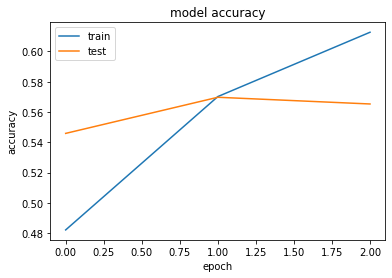

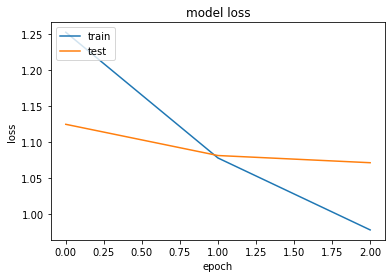

In [69]:
plot_history(history)

In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [114]:

predictions = model.predict(test_cnn_data, 
                            batch_size=1024, 
                            verbose=1)
# labels = [1, 0]
# prediction_labels=[]
# for p in predictions:
#     prediction_labels.append(labels[np.argmax(p)])
# sum(data_test.Label==prediction_labels)/len(prediction_labels)
predictions

18/18 [==============================] - 26s 1s/step


array([[1.33907758e-02, 8.20359439e-02, 1.22340672e-01, 2.97975659e-01,
        4.84256893e-01],
       [8.60797524e-01, 2.90921278e-04, 3.73194623e-03, 1.28386170e-01,
        6.79353159e-03],
       [9.65813249e-02, 3.72616172e-01, 3.27636898e-01, 1.32654369e-01,
        7.05111846e-02],
       ...,
       [2.08029225e-01, 8.67555365e-02, 1.49452895e-01, 4.28739876e-01,
        1.27022475e-01],
       [1.24564385e-02, 4.37932789e-01, 4.28853542e-01, 1.00771524e-01,
        1.99857261e-02],
       [7.03792460e-03, 2.21340358e-01, 1.79517224e-01, 1.02585025e-01,
        4.89519387e-01]], dtype=float32)

In [115]:
preds = predictions.copy()
preds_categorical = []
for prediction in preds:
    preds_categorical.append(np.argmax(prediction))
    print(np.argmax(prediction))

4
0
1
1
0
4
2
1
4
4
4
4
1
0
2
4
3
1
0
4
0
0
4
4
2
4
0
0
0
3
1
4
2
0
0
2
2
0
1
1
4
2
0
3
0
4
0
0
0
4
4
4
1
4
2
0
3
4
1
4
0
0
0
4
4
4
0
4
0
3
4
1
1
0
0
3
2
3
0
0
4
0
3
4
2
2
2
4
4
0
1
4
3
0
4
2
4
2
1
3
2
2
2
1
0
0
0
0
4
0
2
1
2
2
2
0
0
2
0
2
1
0
0
4
2
4
1
0
1
1
2
1
0
3
4
0
2
0
0
1
1
4
4
0
1
1
1
0
1
0
0
0
3
2
1
1
1
2
3
2
0
1
0
0
1
0
0
0
2
1
2
2
1
0
0
0
2
4
1
2
4
0
1
0
0
1
1
1
0
1
1
0
3
0
3
0
2
1
4
0
3
0
4
0
2
0
4
1
0
3
0
1
0
1
1
0
0
2
3
2
0
2
1
0
3
1
0
1
0
2
4
3
0
0
4
0
2
0
0
2
1
0
1
1
0
4
0
0
0
0
0
1
0
2
0
3
3
1
1
3
4
2
2
0
4
1
1
1
3
0
1
4
1
4
0
0
0
0
1
1
3
1
1
0
1
3
0
1
2
4
4
0
2
2
1
0
2
4
0
0
1
0
4
1
0
0
4
3
0
0
3
3
0
1
3
4
0
1
0
4
1
3
1
3
3
0
1
4
1
1
3
1
4
4
1
4
4
0
1
0
0
2
2
0
3
0
2
0
2
1
4
0
0
4
1
2
4
1
1
0
0
4
1
0
0
4
0
3
2
3
0
4
3
1
1
0
4
0
4
0
2
0
1
2
4
0
2
0
0
1
1
2
0
4
1
4
2
0
0
0
3
1
1
1
4
3
0
4
1
1
3
4
2
4
0
2
4
1
4
1
1
0
4
4
2
0
2
3
1
1
0
0
1
0
0
0
0
4
0
2
2
2
0
4
4
4
0
4
4
1
1
1
0
3
1
4
4
1
0
2
3
1
3
0
1
1
1
0
4
2
4
3
0
2
0
2
0
3
1
4
2
0
3
4
4
4
0
1
0
0
0
3
4
4
0
3
2
3
4
1


2
2
0
0
2
1
0
3
1
0
4
2
0
4
4
0
0
1
1
4
0
0
4
0
4
4
4
2
4
3
4
3
3
3
2
0
4
1
1
0
4
0
1
4
4
2
0
0
0
1
2
0
1
0
3
3
2
4
0
2
2
4
0
0
4
0
0
1
3
3
2
4
2
1
3
1
3
4
1
1
0
0
4
0
1
4
4
2
4
4
0
0
0
4
3
0
0
3
0
1
0
2
0
0
3
3
0
4
0
0
1
1
0
1
2
0
0
4
1
2
2
1
0
0
4
2
4
0
4
0
1
4
4
2
0
0
0
4
0
1
0
3
1
0
0
3
4
3
2
0
4
1
1
4
1
0
2
4
1
2
4
4
2
2
0
4
0
0
0
4
1
1
0
4
1
0
0
2
4
0
2
3
0
1
1
1
2
1
0
0
2
0
4
0
1
0
3
4
1
0
0
0
0
0
1
0
3
0
4
1
0
0
2
2
3
1
1
2
2
4
0
2
4
4
3
3
0
2
0
4
1
0
2
2
0
4
0
2
0
1
2
2
1
2
0
1
3
1
0
4
4
4
2
2
3
4
2
3
4
4
2
0
0
1
4
4
2
4
1
2
0
2
1
4
3
3
1
1
1
0
3
2
4
0
1
0
1
3
4
2
0
2
0
2
3
0
4
0
3
2
1
1
1
4
3
4
4
1
4
0
2
0
3
4
2
4
4
0
0
1
1
0
1
1
2
1
2
2
4
4
4
2
0
1
2
2
1
0
1
0
0
0
4
4
2
1
2
2
1
3
2
1
4
2
1
0
0
2
0
0
0
3
4
1
0
4
1
2
4
2
0
0
3
2
3
4
4
2
0
0
1
2
0
4
2
4
0
0
2
3
2
0
0
4
3
2
4
2
2
1
2
0
2
2
0
0
0
2
0
2
1
2
2
4
0
2
2
4
2
0
4
3
0
1
0
4
1
2
4
4
0
2
0
0
1
0
0
0
2
2
1
2
3
4
0
0
0
0
3
0
1
4
1
1
0
1
0
3
0
0
1
0
1
2
2
1
0
2
0
1
2
4
4
0
3
0
2
2
2
4
2
0
1
3
2
3
0
0
1
1
3
4
1
3
3
3
0
0
2
0


1
3
1
4
0
3
1
2
1
0
2
2
0
1
0
3
1
3
0
1
1
1
0
2
2
0
3
2
2
1
4
2
4
3
1
0
0
2
0
0
4
0
2
0
1
0
1
2
0
2
1
1
0
4
1
1
2
3
0
0
1
0
0
0
1
0
2
2
4
3
1
4
4
4
0
2
4
0
3
4
4
1
1
2
1
4
2
4
2
1
3
0
4
4
3
1
3
0
4
2
4
4
0
4
2
4
0
3
0
0
4
0
4
1
3
1
3
4
4
2
4
0
4
1
4
0
1
3
4
2
1
0
1
0
0
1
4
3
0
2
0
2
1
0
0
2
2
2
3
2
1
0
4
0
2
4
0
1
2
0
4
0
4
1
2
1
0
4
3
1
0
0
0
3
0
3
0
4
0
2
0
3
1
0
0
1
0
4
1
0
0
1
0
0
3
4
3
1
0
0
1
2
0
1
1
0
2
4
4
4
1
3
3
1
0
4
3
2
4
3
2
1
0
4
0
4
4
1
0
0
4
0
3
0
3
4
1
4
2
0
1
2
0
0
0
0
0
4
0
0
0
4
0
4
4
0
0
0
2
4
0
4
1
0
3
0
1
0
1
1
1
4
1
4
4
1
0
1
4
1
3
3
3
0
1
3
0
2
1
0
0
3
0
0
2
0
4
0
2
2
0
4
0
2
2
0
0
0
2
3
0
0
4
4
0
2
1
2
0
0
3
1
1
0
3
0
0
4
1
1
0
0
0
0
3
1
0
4
0
0
0
1
4
1
3
0
3
3
2
3
0
4
2
4
0
1
1
0
4
4
0
4
1
4
3
3
0
4
1
4
4
0
0
0
0
4
0
0
4
1
1
1
0
4
1
0
2
1
0
2
2
4
0
0
1
2
0
3
1
0
4
4
1
2
2
4
4
2
2
0
1
0
4
0
1
2
1
1
2
2
0
1
2
4
4
0
3
1
4
2
2
0
1
4
4
1
2
1
3
0
1
2
4
1
1
4
4
0
1
4
2
3
3
3
2
1
1
2
1
0
3
2
0
1
0
1
2
1
0
0
0
0
0
1
0
4
2
0
2
0
0
0
4
3
0
1
3
0
2
1
1
1
4
4
3
0
0
0
0
1


1
1
0
0
1
2
0
0
4
4
4
1
2
2
1
1
4
1
0
0
4
0
0
0
4
0
1
3
4
2
4
4
0
0
2
1
2
4
2
4
4
0
4
4
2
0
2
1
0
1
3
0
2
0
1
1
3
4
2
0
1
2
0
3
0
1
0
0
2
1
0
4
1
3
4
4
2
0
4
2
0
3
2
4
4
1
0
1
2
1
3
2
2
4
0
4
1
4
3
2
0
1
3
0
4
0
1
0
2
1
3
4
1
4
2
0
2
4
2
4
0
0
2
1
0
0
4
3
0
0
0
2
2
2
2
2
1
4
0
1
4
3
3
3
2
0
1
4
4
3
0
2
1
1
0
0
1
3
3
4
0
2
0
3
4
0
1
4
2
3
0
4
2
2
3
0
2
0
4
4
1
2
0
2
2
1
4
0
1
2
0
2
1
0
3
4
4
2
4
0
0
3
0
3
3
0
4
3
4
4
3
4
2
4
0
2
4
4
1
4
0
4
3
0
0
2
1
2
4
4
4
0
1
0
0
1
3
1
4
1
2
2
1
0
1
2
0
2
1
1
0
3
2
2
4
3
0
0
2
4
1
0
0
1
2
0
3
2
0
2
2
4
0
4
4
2
0
4
1
4
0
4
4
0
2
4
2
4
0
0
3
2
4
3
1
2
4
1
2
1
4
2
4
0
0
2
1
3
2
0
2
0
2
0
0
4
4
1
4
2
0
1
4
0
4
2
2
0
3
4
3
2
4
2
4
0
1
0
2
0
0
1
3
1
1
3
4
3
1
0
0
4
1
4
4
1
0
2
2
2
0
2
0
0
1
2
4
0
4
1
0
1
3
1
1
2
3
1
0
1
4
4
2
0
1
4
2
0
1
0
0
2
2
2
2
4
0
1
3
4
1
2
2
4
3
4
4
2
4
2
4
2
0
0
4
1
4
4
0
3
4
1
1
0
0
1
1
2
0
0
1
4
2
0
4
0
1
0
4
2
0
0
0
0
1
1
3
0
0
2
2
4
1
1
1
0
3
2
1
3
4
0
1
3
0
0
0
2
4
2
4
2
4
4
1
3
1
0
3
2
4
1
4
2
4
0
1
4
2
0
1
4
0
1
4
4
2
0
0
2


4
3
1
4
1
0
2
2
0
1
0
1
1
0
4
3
4
1
3
4
1
1
2
2
4
4
2
0
2
2
0
1
3
1
2
1
1
4
2
0
1
1
0
4
4
3
2
1
0
1
0
3
4
0
3
0
1
4
1
4
0
4
4
4
1
1
4
4
4
1
0
2
0
2
4
3
4
2
3
0
4
0
0
1
1
4
2
0
1
0
4
0
4
4
1
4
2
0
4
1
4
0
1
0
4
0
3
1
3
0
0
1
0
0
1
0
4
1
2
4
0
0
1
1
0
1
2
3
4
4
0
4
3
0
2
1
0
1
0
4
4
0
4
1
2
0
1
1
4
3
4
0
1
0
0
1
1
4
2
3
0
1
0
1
4
4
4
4
4
4
4
1
2
1
4
4
0
3
4
4
3
4
0
0
0
2
0
4
4
4
1
0
2
1
4
4
4
3
0
0
0
4
4
0
2
4
0
0
1
1
2
0
0
2
2
2
0
1
0
0
0
0
0
0
2
1
0
2
3
1
1
0
0
1
0
1
0
4
3
0
3
2
0
4
2
3
0
4
4
1
2
1
0
3
4
4
0
0
3
0
0
4
1
0
0
1
2
0
3
0
0
0
1
0
0
0
3
1
1
1
2
3
2
1
3
4
2
0
1
2
2
2
2
1
1
0
2
0
0
4
0
0
4
4
0
4
3
0
0
4
1
0
1
0
4
4
0
4
0
2
3
3
4
4
0
0
0
3
1
1
1
2
0
0
0
1
4
3
1
1
3
1
1
3
1
1
0
3
1
0
0
2
4
0
3
4
4
0
1
1
3
0
4
4
0
0
4
0
4
2
0
4
4
4
2
0
4
1
2
0
1
3
4
1
3
4
3
0
1
0
0
4
4
2
3
4
4
1
0
1
2
2
0
2
0
2
2
2
0
0
2
1
1
1
0
1
0
4
0
4
0
0
1
2
1
2
2
0
1
0
4
3
4
0
0
2
4
1
1
3
0
2
0
2
0
2
4
0
3
2
1
0
4
1
4
4
1
0
0
2
4
2
0
0
3
3
2
2
1
4
0
0
4
4
1
0
0
1
1
2
4
0
1
1
0
3
3
1
4


In [111]:
print(preds)

[[1.33907758e-02 8.20359439e-02 1.22340672e-01 2.97975659e-01
  4.84256893e-01]
 [8.60797524e-01 2.90921278e-04 3.73194623e-03 1.28386170e-01
  6.79353159e-03]
 [9.65813249e-02 3.72616172e-01 3.27636898e-01 1.32654369e-01
  7.05111846e-02]
 ...
 [2.08029225e-01 8.67555365e-02 1.49452895e-01 4.28739876e-01
  1.27022475e-01]
 [1.24564385e-02 4.37932789e-01 4.28853542e-01 1.00771524e-01
  1.99857261e-02]
 [7.03792460e-03 2.21340358e-01 1.79517224e-01 1.02585025e-01
  4.89519387e-01]]


In [112]:
preds_categorical = to_categorical(preds_categorical)
preds_categorical

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [106]:
y_test_cat

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
f1 = f1_score(y_test_cat, preds_categorical, average='weighted')

TypeError: 'numpy.float64' object is not callable

In [ ]:
f1_score

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cat, preds_categorical))

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      4760
           1       0.44      0.65      0.52      2783
           2       0.46      0.39      0.42      3494
           3       0.44      0.27      0.33      3067
           4       0.61      0.54      0.57      4278

   micro avg       0.54      0.54      0.54     18382
   macro avg       0.52      0.52      0.51     18382
weighted avg       0.53      0.54      0.53     18382
 samples avg       0.54      0.54      0.54     18382



In [91]:
sentiment_coding

{'anger': 0, 'joy': 4, 'worry': 2, 'sad': 1, 'neutral': 3}